In [53]:
import pandas as pd
import dtaidistance.dtw_ndim
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import dtaidistance
from dtaidistance import dtw_ndim
from dtaidistance import dtw_visualisation
from dtaidistance import dtw_ndim_visualisation
import numpy as np
import matplotlib.pyplot as plt
import time
from random import randint
from tqdm import tqdm_notebook
from scipy.io import arff
%matplotlib inline

In [94]:
def MDTW_L2_dist(v1, v2, window=None):
    return dtaidistance.dtw_ndim.distance(v1, v2, window=window)

def MDTW_L2_path(matr):
    return dtaidistance.dtw.best_path(matr)

def MDTW_L2_matr(v1, v2):
    return dtaidistance.dtw_ndim.warping_paths(v1, v2)

def MDTW_L2_visualisation(v1, v2, path):
    # another way to visualise
    # dtaidistance.dtw_ndim_visualisation.plot_warping(v1, v2, path)
    for i in range(v1.shape[1]):
        dtaidistance.dtw_visualisation.plot_warping(v1[:, i], v2[:, i], path)
        
#def prepare_data(data):
#    return data.reshape(data.shape[0], data.shape[1] * data.shape[2])

#def MDTW_L2_dist_1d(v1, v2):
#    return data.reshape()

In [55]:
def MDTW_DTW_dist(v1, v2, metric=dtaidistance.dtw.distance, window=None):
    n = len(v1)
    m = len(v2)
    dp = np.zeros((n + 1, m + 1))
    dp[0][0] = 0
    for i in range(1, n + 1):
        dp[i][0] = np.inf
    for i in range(1, m + 1):
        dp[0][i] = np.inf
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            if window is None or abs(i - j) < window:
                dp[i][j] = metric(v1[i - 1], v2[j - 1]) ** 2 + min(dp[i - 1][j], dp[i][j - 1], dp[i - 1][j - 1])
            elif abs(i - j) == window:
                if i - j == window:
                    dp[i][j] = metric(v1[i - 1], v2[j - 1]) ** 2 + min(dp[i - 1][j], dp[i - 1][j - 1])
                else:
                    dp[i][j] = metric(v1[i - 1], v2[j - 1]) ** 2 + min(dp[i][j - 1], dp[i - 1][j - 1])
            else:
                dp[i][j] = np.inf
                
    return dp[n][m] ** 0.5

In [99]:
def MDTW_DTW_matr(v1, v2, metric=dtaidistance.dtw.distance, window=None):
    n = len(v1)
    m = len(v2)
    dp = np.zeros((n + 1, m + 1))
    dp[0][0] = 0
    for i in range(1, n + 1):
        dp[i][0] = np.inf
    for i in range(1, m + 1):
        dp[0][i] = np.inf
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            if window is None or abs(i - j) < window:
                dp[i][j] = metric(v1[i - 1], v2[j - 1]) ** 2 + min(dp[i - 1][j], dp[i][j - 1], dp[i - 1][j - 1])
            elif abs(i - j) == window:
                if i - j == window:
                    dp[i][j] = metric(v1[i - 1], v2[j - 1]) ** 2 + min(dp[i - 1][j], dp[i - 1][j - 1])
                else:
                    dp[i][j] = metric(v1[i - 1], v2[j - 1]) ** 2 + min(dp[i][j - 1], dp[i - 1][j - 1])
            else:
                dp[i][j] = np.inf
    return dp ** 0.5
   
    
def MDTW_DTW_path(v1, v2, matr):
    time_path = dtaidistance.dtw.best_path(matr)
    signal_path = []
    for el in time_path:
        matr = MDTW_L2_matr(v1[el[0]], v2[el[1]])[1]
        signal_path.append(dtaidistance.dtw.best_path(matr))
    return (time_path, signal_path)


def MDTW_DTW_visualisation(v1, v2, path):
    time_path, signal_path = path
    for i in range(len(time_path)):
        print('1 time series signal ' + str(time_path[i][0]) + '\n' +
                  '2 time series signal ' + str(time_path[i][1]))
        dtaidistance.dtw_visualisation.plot_warping(v1[time_path[i][0]], v2[time_path[i][1]], signal_path[i])
        #fig.title('Выравниваются {} и {} временные ряды'.format(time_path[i][0] + 1, time_path[i][1] + 1)
        plt.show()

In [57]:
def prepare_data(data):
    return data.reshape(data.shape[0], data.shape[1] * data.shape[2])

    
def prepared_L2(left, right):
    #print(left.shape, right.shape)
    return MDTW_L2_dist(left.reshape(dim, left.shape[0] // dim),
                        right.reshape(dim, right.shape[0] // dim))


def prepared_DTW(left, right):
    return MDTW_DTW_dist(left.reshape(dim, left.shape[0] // dim),
                        right.reshape(dim, right.shape[0] // dim))

In [58]:
class Experiment:
    def __init__(self, data, labels, eps=1e-9):
        self.data = data
        self.labels = labels
        self.eps = 1e-9
    
    def calc_dist_experiment(self, idx1, idx2):
        print(idx1, idx2, MDTW_L2_dist(self.data[idx1], self.data[idx2]) ** 2)
        print(idx1, idx2, MDTW_DTW_dist(self.data[idx1], self.data[idx2]) ** 2)
        
    def description_dist(self):
        equals = 0
        less = 0
        greater = 0
        max_diff = 0
        mean_diff = 0
        max_idx1 = 0
        max_idx2 = 0
        for idx1 in tqdm_notebook(range(len(self.data))):
            for idx2 in tqdm_notebook(range(len(self.data))):
                dst1 = MDTW_L2_dist(self.data[idx1], self.data[idx2])
                dst2 = MDTW_DTW_dist(self.data[idx1], self.data[idx2])
                if dst1 == dst2 or abs(dst1 - dst2) < self.eps:
                    equals += 1
                elif dst1 < dst2:
                    less += 1
                else:
                    greater += 1
                if dst1 - dst2 > max_diff:
                    max_diff = dst1 - dst2
                    max_idx1 = idx1
                    max_idx2 = idx2
                mean_diff += dst1 - dst2
        mean_diff /= len(data) * len(data)
        print('Calculate distance experiment results:')
        print('L2 = DTW', equals)
        print('L2 < DTW', less)
        print('L2 > DTW', greater)
        print('Maximum difference between L2 and DTW:', max_diff)
        print('Indexes of maximum difference:', max_idx1, max_idx2)
        print('Mean value of difference:', mean_diff)
        
    def time_experiment(self, iter_count=100, cnt_signals=None, info=True):
        if cnt_signals is None:
            cnt_signals = self.data.shape[1]
        L2_time = {'min': np.inf, 'max': 0, 'mean': 0}
        DTW_time = {'min': np.inf, 'max': 0, 'mean': 0}
        for i in range(iter_count):
            idx1 = randint(0, len(self.data) - 1)
            idx2 = randint(0, len(self.data) - 1)
            begin = time.time()
            MDTW_L2_dist(self.data[idx1][:cnt_signals], self.data[idx2][:cnt_signals])
            end = time.time()
            L2_time['min'] = min(L2_time['min'], end - begin)
            L2_time['max'] = max(L2_time['max'], end - begin)
            L2_time['mean'] += (end - begin) / iter_count
            
            begin = time.time()
            MDTW_DTW_dist(self.data[idx1][:cnt_signals], self.data[idx2][:cnt_signals])
            end = time.time()
            DTW_time['min'] = min(DTW_time['min'], end - begin)
            DTW_time['max'] = max(DTW_time['max'], end - begin)
            DTW_time['mean'] += (end - begin) / iter_count
            
        if info:
            print('L2 time result:')
            print('min:', L2_time['min'])
            print('max:', L2_time['max'])
            print('mean:', L2_time['mean'])
        
            print('DTW time result:')
            print('min:', DTW_time['min'])
            print('max:', DTW_time['max'])
            print('mean:', DTW_time['mean'])
        return (L2_time, DTW_time)
    
    #def _prepare_data(self, data):
    #    return data.reshape(data.shape[0], data.shape[1] * data.shape[2])
    
    #def _prepared_L2(self, prepared_data):
    #    data = prepared_data.reshape(self.data.shape[0], self.data.shape[1], self.data.shape[2])
        
    
            
    def KNeighbourClassifier_test(self, window=None):
        data = prepare_data(self.data)
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(data, self.labels,
                                                                                   test_size=0.3)
        #print(data, self.labels)
        #print(self.X_train, self.X_test, self.y_train, self.y_test)
        
        model_L2 = KNeighborsClassifier(n_neighbors=5, metric=prepared_L2)
        model_L2.fit(self.X_train, self.y_train)
        predicted_L2 = model_L2.predict(self.X_test)
        accuracy_L2 = accuracy_score(self.y_test, predicted_L2)
            
        model_DTW = KNeighborsClassifier(n_neighbors=1, metric=prepared_DTW)
        model_DTW.fit(self.X_train, self.y_train)
        predicted_DTW = model_DTW.predict(self.X_test)
        accuracy_DTW = accuracy_score(self.y_test, predicted_DTW)
        
        print(predicted_L2)
        print(predicted_DTW)
        print(accuracy_L2, accuracy_DTW)
        
            
        return (accuracy_L2, accuracy_DTW)

In [59]:
df = arff.loadarff('../data/EEG_Eye_State.arff')
data = pd.DataFrame(df[0])

#data = pd.read_csv('EEG_Eye_State.arff')

In [60]:
data

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85,b'0'
1,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10,b'0'
2,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,b'0'
3,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,b'0'
4,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46,b'0'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14975,4281.03,3990.26,4245.64,4116.92,4333.85,4614.36,4074.87,4625.64,4203.08,4221.54,4171.28,4269.23,4593.33,4340.51,b'1'
14976,4276.92,3991.79,4245.13,4110.77,4332.82,4615.38,4073.33,4621.54,4194.36,4217.44,4162.56,4259.49,4590.26,4333.33,b'1'
14977,4277.44,3990.77,4246.67,4113.85,4333.33,4615.38,4072.82,4623.59,4193.33,4212.82,4160.51,4257.95,4591.79,4339.49,b'1'
14978,4284.62,3991.79,4251.28,4122.05,4334.36,4616.41,4080.51,4628.72,4200.00,4220.00,4165.64,4267.18,4596.41,4350.77,b'1'


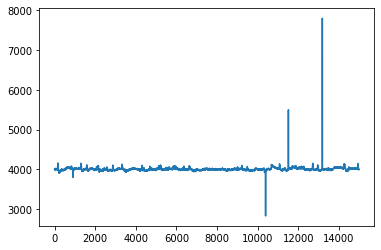

In [61]:
data.F7.plot()

In [62]:
dim = 4
class1 = data[data.eyeDetection == b'0']
class2 = data[data.eyeDetection == b'1']
class1.drop(columns=['eyeDetection'], inplace=True)
class2.drop(columns=['eyeDetection'], inplace=True)
data_class1 = np.array(class1)
data_class2 = np.array(class2)

#print(class1.shape)

#print(class2.shape)

#print(np.array(class1), np.array(class2))

/home/kulpet345/anaconda3/envs/mipt-stats/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [68]:
print(data_class1.shape, data_class2.shape)

(8257, 14) (6723, 14)


4
1 time series signal 0
2 time series signal 0


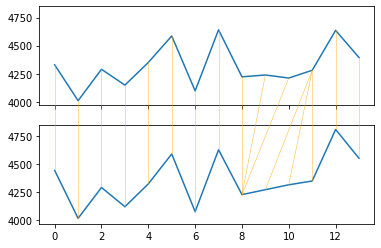

1 time series signal 1
2 time series signal 1


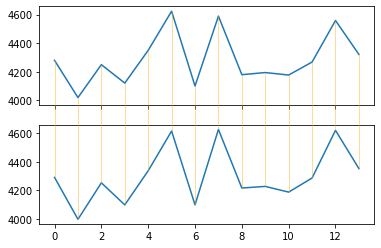

1 time series signal 2
2 time series signal 2


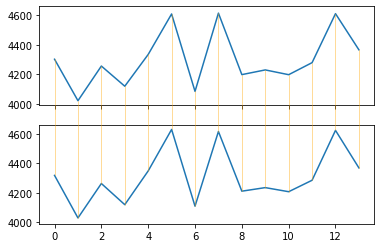

1 time series signal 3
2 time series signal 3


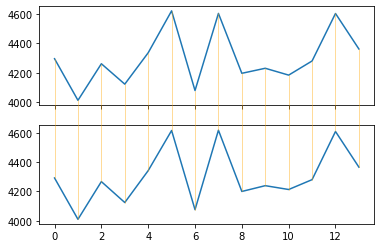

In [100]:
ts1 = data_class1[range(0, 1000, 300)]
ts2 = data_class2[range(0, 1000, 300)]
#print(ts1.shape)
matr = MDTW_DTW_matr(ts1, ts2)
path = MDTW_DTW_path(ts1, ts2, matr)
print(len(path[0]))
MDTW_DTW_visualisation(ts1, ts2, path)

In [70]:
cnt = 0
result = 0
result1 = 0
result2 = 0

for i in range(30, min(len(data_class1), len(data_class2)), 30):
    val1, val2 = experiment(data_class1[:i], data_class2[:i], dim=4, cnt_signals=i // 30)
    cnt += 1
    if val2 > val1:
        result += 1
    if val2 == val1:
        result1 += 1
    if val2 < val1:
        result2 += 1
    
#print(result / cnt, result1 / cnt, result2 / cnt)

[1 0 0 0 0 1 0 1 1 1 0 0 0 0 1 1 0 0]
[1 0 0 0 0 1 0 1 1 1 0 0 0 0 1 1 0 0]
1.0 1.0
[0 1 1 0 1 0 0 0 1 0 0 1 0 0 1 1 0 0]
[0 1 1 0 1 0 0 0 1 0 0 1 0 0 1 1 0 0]
1.0 1.0
[1 1 0 1 0 1 1 1 0 1 1 0 0 0 1 0 0 0]
[1 1 0 1 0 1 1 1 0 1 1 0 0 0 1 0 0 0]
1.0 1.0
[0 1 1 0 0 1 0 1 0 1 0 1 1 1 0 1 0 0]
[0 1 1 0 0 1 0 1 0 1 0 1 1 1 0 1 0 0]
1.0 1.0
[0 1 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 0]
[0 1 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 0]
1.0 1.0
[1 1 0 1 0 1 0 1 0 0 1 1 1 1 1 0 0 0]
[1 1 0 1 0 1 0 1 0 0 1 1 1 1 1 0 0 0]
1.0 1.0
[0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1]
[0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1]
1.0 1.0
[0 1 1 1 1 1 0 0 0 1 1 1 1 0 0 1 0 0]
[0 1 1 1 1 1 0 0 0 1 1 1 1 0 0 1 0 0]
1.0 1.0
[0 1 1 1 0 0 1 0 0 0 1 1 0 1 0 1 1 0]
[0 1 1 1 0 0 1 0 0 0 1 1 0 1 0 1 1 0]
1.0 1.0
[0 0 1 0 1 0 1 0 1 1 0 0 0 1 1 0 1 1]
[0 0 1 0 1 0 1 0 1 1 0 0 0 1 1 0 1 1]
1.0 1.0
[1 1 1 1 0 1 0 1 0 1 0 0 1 1 1 0 0 0]
[1 1 1 1 0 1 0 1 0 1 0 0 1 1 1 0 0 0]
1.0 1.0
[0 1 1 0 0 0 0 1 1 1 0 1 1 1 1 1 0 1]
[0 1 1 0 0 0 0 1 1 1 0 1 1 1 1 1 0 1]


KeyboardInterrupt: 

In [71]:
print(result / cnt, result1 / cnt, result2 / cnt)

0.09090909090909091 0.9090909090909091 0.0


In [74]:
cnt = 0
result = 0
result1 = 0
result2 = 0
dim = 14

for i in range(30, min(len(data_class1), len(data_class2)), 30):
    val1, val2 = experiment(data_class1[:i], data_class2[:i], dim=14, cnt_signals=i // 30)
    cnt += 1
    if val2 > val1:
        result += 1
    if val2 == val1:
        result1 += 1
    if val2 < val1:
        result2 += 1
    
print(result / cnt, result1 / cnt, result2 / cnt)

[0 0 0 1 1 1 0 1 0 0 1 1 0 1 1 0 1 0]
[0 0 0 1 1 1 0 1 0 0 1 1 0 1 1 0 1 0]
1.0 1.0
[0 0 0 1 0 0 0 0 0 1 1 0 0 1 1 1 0 1]
[0 0 0 1 0 0 0 0 0 1 1 0 0 1 1 1 0 1]
1.0 1.0
[0 0 1 0 1 1 1 1 0 1 1 0 0 1 1 0 1 0]
[0 0 1 0 1 1 1 1 0 1 1 0 0 1 1 0 1 0]
1.0 1.0
[0 0 0 1 1 1 1 0 1 0 0 0 0 0 1 1 0 1]
[0 0 0 1 1 1 1 0 1 0 0 0 0 0 1 1 0 1]
1.0 1.0
[1 1 0 0 1 1 0 1 1 1 0 1 0 0 1 1 1 0]
[1 1 0 0 1 1 0 1 1 1 0 1 0 0 1 1 1 0]
1.0 1.0
[0 0 0 1 1 0 0 1 1 0 0 0 0 1 1 0 0 0]
[0 0 0 1 1 0 0 1 1 0 0 0 0 1 1 0 0 0]
1.0 1.0
[0 0 1 0 0 0 1 0 0 1 1 0 1 1 1 1 0 0]
[0 0 1 0 0 0 1 0 0 1 1 0 1 1 1 1 0 0]
1.0 1.0
[1 1 1 1 1 1 1 0 0 0 1 1 1 0 0 1 0 1]
[1 1 1 1 1 1 1 0 0 0 1 1 1 0 0 1 0 1]
1.0 1.0
[1 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 0 0]
[1 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 0 0]
1.0 1.0
[0 0 1 1 1 1 0 0 0 0 1 1 0 0 1 1 0 1]
[0 0 1 1 1 1 0 0 0 0 1 1 0 0 1 1 0 1]
1.0 1.0
[0 0 1 0 0 1 1 0 0 0 0 0 1 0 1 1 0 0]
[0 0 1 0 0 1 1 0 0 0 0 0 1 0 1 1 0 0]
0.9444444444444444 0.9444444444444444
[0 0 1 0 1 0 1 0 0 0 0 0 1 1 1 0 1 0]
[0 0 1 0

KeyboardInterrupt: 

In [46]:
def experiment(data_class1, data_class2, sample_size=30, cnt_signals=30, dim=10):
    data_class1 = data_class1[:, :dim]
    data_class2 = data_class2[:, :dim]
    time_series1 = []
    time_series2 = []
    
    for i in range(sample_size):
        time_series1.append(data_class1[i + sample_size * np.arange(cnt_signals)])
        time_series2.append(data_class2[i + sample_size * np.arange(cnt_signals)])
    time_series1 = np.array(time_series1)
    time_series2 = np.array(time_series2)
    labels = []
    data = []

    for i in range(sample_size):
        data.append(time_series1[i])
        data.append(time_series2[i])
        labels.append(0)
        labels.append(1)
    data = np.array(data)
    labels = np.array(labels)
        
    exp = Experiment(data, labels)
    return exp.KNeighbourClassifier_test()

In [ ]:
data_time = []
for i in range(10, 100):
    data_time = data_class1[:i] + data_class2[:i]
    labels_time = [0] * i + [1] * i
    exp = Experiment(data_time, labels_time)